In [28]:
import uproot
import numpy as np
import pandas as pd
import awkward as ak
import vector
import matplotlib
import matplotlib.pyplot as plt
import itertools
import json
import h5py
import sys
sys.path.append('../')
from Plotter import *
from sigfig import round


In [2]:
plotting_info = json.load(open('../plotting_info.json'))
model_specs = plotting_info['model_specs']
plot_specs = plotting_info['plot_specs']
par_specs = plotting_info['par_specs']

f_test = h5py.File(plotting_info['test_filename'],'r')
eventnumbers = np.array(f_test.get('eventNumber'))
total_test_events = len(np.array(f_test.get('eventNumber')))
f_test.close()

In [3]:
def unpack_observables(obs_specs):
    """
    Unpacks the observable definitions from the given dictionary (likely from a JSON file).

        Parameters:
            obs_specs (dict): Observable specifications, including name of the observables, alternative names, labels, units, and starting point, stopping point, and step size for the bins.

        Returns:
            observables (list of observable objects): Observables
    """

    # Create a list to store the observables in
    observables = []

    # For each observable specified ...
    for obs in obs_specs:

        # Get the ticks for the bins
        ticks = np.arange(obs['start'],obs['stop'],obs['step'])

        # Create the observable object and append it to the list
        observables.append(Observable(obs['name'],obs['label'],ticks,unit=obs['unit'],res=obs['res'],alt_names=obs['alt_names']))
    
    return observables



def unpack_particles(par_specs):
    """
    Unpacks the particle definitions from the given dictionary (likely from a JSON file).

        Parameters:
            par_specs (dict): Particle specifications, including name of the particles, alternative names, labels, and observables

        Returns:
            particles (list of particle objects): Particles
    """

    # Create a list to store the particles in
    particles = []

    # For each particle specified ...
    for par, specs in par_specs.items():

        # Get the observables for that particle
        observables = unpack_observables(specs['observables'])

        # Create the particle object and append it to the list
        particles.append(Particle(par,specs['label'],observables,alt_names=specs['alt_names']))

    return particles



def Get_List_Of_Things_To_Load(plotting_instr):
    """
    Gets lists of the models and systematics we'll need to load to make the desired plots.

        Parameters:
            plotting_instr (dict): Dictionary containing the types of plots we want to make and their specifications (from the JSON file).

        Returns:
            models_to_load (list of str): Names of the models we'll need data from.
            sys_to_load (list of str): Names of the models we'll need systematics from.
    """

    models_to_load = []
    sys_to_load = []
    for plot_type, instr in plotting_instr.items():
        if plot_type=='TruthReco':
            for model_name, model_instr in instr['models'].items():
                if model_instr['plot']:
                    models_to_load.append(model_name) if model_name not in models_to_load else models_to_load
                if model_instr['include_systematics']:
                    sys_to_load.append(model_name) if model_name not in sys_to_load else sys_to_load
        elif plot_type=='CM':
            for model_name, model_instr in instr['models'].items():
                if model_instr['plot']:
                    models_to_load.append(model_name) if model_name not in models_to_load else models_to_load
        elif plot_type=='Sys':
            for model_name, plot_model in instr['include_model'].items():
                if plot_model:
                    models_to_load.append(model_name) if model_name not in models_to_load else models_to_load
                    sys_to_load.append(model_name) if model_name not in sys_to_load else sys_to_load
        else:
            for model_name, plot_model in instr['include_model'].items():
                if plot_model:
                    models_to_load.append(model_name) if model_name not in models_to_load else models_to_load

    print('Preparing to load results for the following models: ',models_to_load)
    print('Preparing to load systematics for the following models: ',sys_to_load)    

    return models_to_load, sys_to_load

particles = unpack_particles(par_specs)
plotting_instr = {}
for plot, specs in plot_specs.items():
    if specs['make_plots']:
        plotting_instr[plot] = plot_specs[plot]
models_to_load,sys_to_load = Get_List_Of_Things_To_Load(plotting_instr)

Preparing to load results for the following models:  ['TRecNet', 'TRecNet+ttbar', 'TRecNet+ttbar+JetPretrain', 'KLFitter6', 'PseudoTop', 'Chi2']
Preparing to load systematics for the following models:  ['TRecNet', 'TRecNet+ttbar', 'TRecNet+ttbar+JetPretrain', 'KLFitter6', 'PseudoTop', 'Chi2']


In [4]:
def readInData(reco_method,filename,eventnumbers):
    """
    Reads data into a dataframe from a file, and removes events that are not part of the test dataset (if list of test event numbers is given).

        Parameters:
            reco_method (str): Name of the reconstruction model (e.g.'KLFitter', 'TRecNet', etc.)
            filename (str): Name, including path, of root file to read data from.
            eventnumbers (list): Event numbers for the test dataset.

        Returns:
            df (pd.DataFrame): Dataframe full of data from the given file.
    """

    print('Reading in data for '+reco_method+' ...')

    # Open root file and its trees
    f = uproot.open(filename)

    # For TRecNet-based models ...
    if 'TRecNet' in reco_method and 'sys' not in reco_method:

        # Load the truth and reco data
        truth_arr = f['parton'].arrays()
        reco_arr = f['reco'].arrays()

        # Create dataframe with truth and reco data, as well as event numbers
        truth_df = ak.to_pandas(truth_arr)
        truth_df = truth_df.add_prefix('truth_')
        reco_df = ak.to_pandas(reco_arr)
        reco_df = reco_df.add_prefix('reco_')
        df = pd.concat([truth_df,reco_df], axis=1)
        df['eventNumber'] = truth_arr['eventNumber']

    # Systematics for TRecNet models
    elif 'TRecNet' in reco_method and 'sys' in reco_method:

        # Get whether it's up or down systematics
        sys_type = reco_method.split('_')[0]

        # Load sys data
        sys_arr = f['reco'].arrays()

        # ISSUE: this is cutting all events! Not sure why but shouldn't matter once it's all the new data? Idk, it really shouldnt be happening
        # Only take events with the same event numbers as the test data
        #sel = np.isin(sys_arr['eventNumber'],eventnumbers)
        #sys_arr = sys_arr[sel]


        # Create dataframe with reco data, as well as event numbers
        df = ak.to_pandas(sys_arr)
        #df = df.drop('index',axis=1) # index not in df I guess

        # Bit of a hack for now:
        # Get whether it's up or down systematics
        sys_type = reco_method.split('_')[0]
        df = df.add_prefix(sys_type+'_')   # Want to add sysUP or sysDOWN prefix to match the other files
        df = df.rename(columns={sys_type+'_eventNumber':'eventNumber',sys_type+'_jet_n':'jet_n',sys_type+'_logLikelihood':'logLikelihood'})

    # Systematics for non-TRecNet models
    elif 'TRecNet' not in reco_method and 'sys' in reco_method:

        # Get whether it's up or down systematics
        sys_type = reco_method.split('_')[0]

        # Load sys data
        sys_arr = f[sys_type].arrays()

        # ISSUE: this is cutting all events! Not sure why but shouldn't matter once it's all the new data? Idk, it really shouldnt be happening
        # Only take events with the same event numbers as the test data
        #sel = np.isin(sys_arr['eventNumber'],eventnumbers)
        #sys_arr = sys_arr[sel]


        # Create dataframe with reco data, as well as event numbers
        df = ak.to_pandas(sys_arr)
        #df = df.drop('index',axis=1) # index not in df I guess

        # Bit of a hack for now:
        #df = df.add_prefix('reco_')
        #df = df.rename(columns={'reco_eventNumber':'eventNumber'})




    # For likelihood-based models ... 
    else:

        # Load truth and reco data
        truth_arr = f['truth'].arrays()
        reco_arr = f['reco'].arrays()

        # ISSUE: this is cutting all events! Not sure why but shouldn't matter once it's all the new data? Idk, it really shouldnt be happening
        # Only take events with the same event numbers as the test data
        sel = np.isin(truth_arr['eventNumber'],eventnumbers)
        truth_arr = truth_arr[sel]
        reco_arr = reco_arr[sel]


        # Create dataframe with truth and reco data, as well as event numbers
        truth_df = ak.to_pandas(truth_arr)
        truth_df = truth_df.drop('index',axis=1)
        reco_df = ak.to_pandas(reco_arr)
        reco_df = reco_df.drop('index',axis=1)
        df = pd.concat([truth_df,reco_df], axis=1)

    

    return df




def Append_Calculations(df,model):
    """
        Calculate a few more observables that we might want to plot.

            Parameters:
                df (pd.DataFrame): Dataframe from which new observables will be calculated and to which they'll be appended.
                model (str): Name of the model for this dataframe.

            Returns:
                df (pd.DataFrame): Input dataframe with the new observables appended.
    """

    # Do so for both truth and reco
    for level in ['truth','reco']:

        # Skip doing this systematics ???? Bit confused about what this is ...
        if level=='truth' and 'sys' in model:
            continue

        # Append calculations for px and py for ttbar 
        df[level+'_ttbar_px'] = df[level+'_ttbar_pt']*np.cos(df[level+'_ttbar_phi'])
        df[level+'_ttbar_py'] = df[level+'_ttbar_pt']*np.sin(df[level+'_ttbar_phi'])

        # Chi2 doesn't have hadronic or leptonic tops, so we can't do the following for that model
        if model!='Chi2':

            # Append calculations for px and py for th and tl
            df[level+'_th_px'] = df[level+'_th_pt']*np.cos(df[level+'_th_phi'])
            df[level+'_th_py'] = df[level+'_th_pt']*np.sin(df[level+'_th_phi'])
            df[level+'_tl_px'] = df[level+'_tl_pt']*np.cos(df[level+'_tl_phi'])
            df[level+'_tl_py'] = df[level+'_tl_pt']*np.sin(df[level+'_tl_phi'])

            # Calculate ttbar deta and append
            th_vec = vector.arr({"pt": df[level+'_th_pt'], "phi": df[level+'_th_phi'], "eta": df[level+'_th_eta'],"mass": df[level+'_th_m']})
            tl_vec = vector.arr({"pt": df[level+'_tl_pt'], "phi": df[level+'_tl_phi'], "eta": df[level+'_tl_eta'],"mass": df[level+'_tl_m']}) 
            df[level+'_ttbar_deta'] = abs(th_vec.deltaeta(tl_vec))

            # If the model is KLFitter or PseudoTop ...
            if model=='KLFitter4' or model=='KLFitter6' or model=='PseudoTop':

                # Calculate and append dphi, Ht, yboost, and ystar for ttbar
                df[level+'_ttbar_dphi'] = abs(th_vec.deltaphi(tl_vec))
                df[level+'_ttbar_Ht'] = df[level+'_th_pt']+df[level+'_tl_pt']
                df[level+'_ttbar_yboost'] = 0.5*(df[level+'_th_y']+df[level+'_tl_y'])
                df[level+'_ttbar_ystar'] = 0.5*(df[level+'_th_y']-df[level+'_tl_y'])


    return df



def convertUnits(df_col,from_units,to_units):

    # Only bother converting if units are actually different
    if from_units!=to_units:

        # Figure out how many eV per the units we're converting from
        from_prefix = from_units[0] if from_units!='eV' else ''
        from_factor = 1 if from_prefix=='' else 10**6 if from_prefix=='M' else 10**9 if from_prefix=='G' else 10**12 if from_prefix=='T' else 0

        # Figure out how many eV per the units we're converting to
        to_prefix = to_units[0] if to_units!='eV' else ''
        to_factor = 1 if to_prefix=='' else 10**6 if to_prefix=='M' else 10**9 if to_prefix=='G' else 10**12 if to_prefix=='T' else 0

        # If we're not prepared to handle this unit, throw an error
        if from_factor==0 or to_factor==0:
            print('Units prefix not recognized (currently recognizes: eV, MeV, GeV or TeV.) Please use one of these, or edit this code.')
            sys.exit()

        # Convert from the previous units to the new units
        df_col = df_col*(from_factor/to_factor)

    return df_col



# CURRENTLY ONLY FOR ENERGY, INCLUDE OTHERS LATER???
def Scale_Data(df,truth_units,reco_units,par_specs):

    # Go through all the observables
    for (par,spec) in par_specs.items():
    	for obs in spec['observables']:
        
            # Look at observables with energy units
            if 'eV' in obs['unit']:

                # Convert from truth units to units specified for the observable
                if 'truth_'+par+'_'+obs['name'] in df.keys():
                    df['truth_'+par+'_'+obs['name']] = convertUnits(df['truth_'+par+'_'+obs['name']],truth_units,obs['unit'])

                # Convert from reco units to units specified for the observable
                if 'reco_'+par+'_'+obs['name'] in df.keys():
                    df['reco_'+par+'_'+obs['name']] = convertUnits(df['reco_'+par+'_'+obs['name']],reco_units,obs['unit'])

    return df


def getCutDF(df,cut_on,max,min):
    """
    Creates a version of the input dataframe with the specified cuts (or lack thereof).

        Parameters:
            df (pd.DataFrame): Base dataframe.
            cut_on (str or None): Name of the thing which is being cut on, or None if no cut is desired.
            max (int or None): Maximum value, or None if there is no maximum desired..
            min (int or None): Minimum value, or None if there is no minimum desired.

        Returns:
            df_cut (pd.DataFrame): Dataframe with the implemented cuts, or the original dataframe if no cuts are desired.
    """

    # Keep data with quantity > min
    if max==None and min!=None:
        df_cut = df[df[cut_on]>min]

    # Keep data with quantity < max
    elif max!=None and min==None:
        df_cut = df[df[cut_on]<max]

    # Keep data with min < quantity < max
    elif max!=None and min!=None:
        df_cut = df[df[cut_on]>min]
        df_cut = df_cut[df_cut[cut_on]<max]

    # No cuts
    else:
        df_cut = df

    return df_cut

In [6]:
# Get the total number of test events and the list of test events
f_test = h5py.File(plotting_info['test_filename'],'r')
eventnumbers = np.array(f_test.get('eventNumber'))
f_test.close()






# Create a dictionary to hold all the datsets
datasets = []

datatype=plotting_info["datatype"]

# Go through each model in the list of those we need to load
for model_name in ['TRecNet','TRecNet+ttbar','TRecNet+ttbar+JetPretrain','KLFitter6','PseudoTop','Chi2']:

    # Create a dataframe for that model, append some other variables we might want to plot, and scale data to desired units of energy
    df = readInData(model_name,model_specs[model_name]["input_file"],eventnumbers)
    #df = Append_Calculations(df,model_name)
    df = Scale_Data(df,model_specs[model_name]["truth_units"],model_specs[model_name]["reco_units"],par_specs)

                
    # We always want systematics
    if True:

        # Create dataframe for up systematics
        up_df = readInData('sysUP_'+model_name,model_specs[model_name]["sysUP_input"],eventnumbers)
        #up_df = Append_Calculations(up_df,'sysUP_'+model_name)
        up_df = Scale_Data(up_df,model_specs[model_name]["truth_units"],model_specs[model_name]["reco_units"],par_specs)

        # Create dataframe for down systematics
        down_df = readInData('sysDOWN_'+model_name,model_specs[model_name]["sysDOWN_input"],eventnumbers)
        #down_df = Append_Calculations(down_df,'sysDOWN_'+model_name)
        down_df = Scale_Data(down_df,model_specs[model_name]["truth_units"],model_specs[model_name]["reco_units"],par_specs)        


        # Create a dataset for each cut of the model we want to look at (is there a better way to do this, like within the plotting framework, so we don't have to make a bunch of dataframes?)
        for cut in model_specs[model_name]["cuts"]:

            # Grab the things we'll need
            cut_on, min, max, tag, color_scheme = cut["cut_on"], cut["min"], cut["max"], cut["tag"], cut["color_scheme"],

            # Get the dataframes with the specified cuts (or lackthereof)
            df_cut = getCutDF(df,cut_on,max,min)
            up_df_cut = getCutDF(up_df,cut_on,max,min)
            down_df_cut = getCutDF(down_df,cut_on,max,min)
                
            # Create the dataset object and append it to our dictionary
            p = int(100*len(df_cut)/total_test_events)
            dataset = Dataset(df_cut,model_name,datatype,color_scheme,sysUP_df=up_df_cut,sysDOWN_df=down_df_cut,shortname=model_specs[model_name]["shortname"],cuts=tag,perc_events=p)
            datasets.append(dataset)


Reading in data for TRecNet ...
Reading in data for sysUP_TRecNet ...
Reading in data for sysDOWN_TRecNet ...
Reading in data for TRecNet+ttbar ...
Reading in data for sysUP_TRecNet+ttbar ...
Reading in data for sysDOWN_TRecNet+ttbar ...
Reading in data for TRecNet+ttbar+JetPretrain ...
Reading in data for sysUP_TRecNet+ttbar+JetPretrain ...
Reading in data for sysDOWN_TRecNet+ttbar+JetPretrain ...
Reading in data for KLFitter6 ...
Reading in data for sysUP_KLFitter6 ...
Reading in data for sysDOWN_KLFitter6 ...
Reading in data for PseudoTop ...
Reading in data for sysUP_PseudoTop ...
Reading in data for sysDOWN_PseudoTop ...
Reading in data for Chi2 ...
Reading in data for sysUP_Chi2 ...
Reading in data for sysDOWN_Chi2 ...


In [24]:
for ds in datasets[:-2]: print(ds.reco_method, ds.cuts)

TRecNet No Cuts
TRecNet+ttbar No Cuts
TRecNet+ttbar+JetPretrain No Cuts
KLFitter6 No Cuts
KLFitter6 LL>-52
PseudoTop No Cuts


In [13]:
trn = datasets[0]
ttbar = datasets[1]
jp = datasets[2]
klf6 = datasets[3]
klf6cuts= datasets[4]
pseudotop = datasets[5]
chi2 = datasets[6]
chi2cuts = datasets[7]

In [96]:
nbins=5
mmin = 100
mmax = 1450
ran = (mmin,mmax)


for ds in datasets[:-2]:

    print('For '+ds.reco_method+' with '+ds.cuts+'('+str(ds.perc_events)+'%)')

    plt.figure('No Density',figsize=(12,9))
    den = False
    reco_n, bins, _ = plt.hist(ds.df['reco_th_E'],bins=nbins,range=ran,histtype='step',density=den,label='nom',color='k')
    sysUP_n, _, _ = plt.hist(ds.sysUP_df['sysUP_th_E'],bins=nbins,range=ran,histtype='step',density=den,label='up',color='r')
    sysDOWN_n, _, _ = plt.hist(ds.sysDOWN_df['sysDOWN_th_E'],bins=nbins,range=ran,histtype='step',density=den,label='down',color='c')
    #plt.legend()
    #plt.show()
    plt.close()
    print('Nominal:',reco_n)
    print('Up:',sysUP_n)
    print('Down:',sysDOWN_n)
    print('\n')


For TRecNet with No Cuts(100%)
Nominal: [2599575. 1002708.  247843.   66066.   18195.]
Up: [19990340.  7629612.  1887195.   505210.   138339.]
Down: [18746186.  7168674.  1771632.   474003.   130047.]


For TRecNet+ttbar with No Cuts(100%)
Nominal: [2602522. 1002315.  246149.   64920.   18106.]
Up: [20034449.  7611483.  1873578.   492409.   136732.]
Down: [18783489.  7153273.  1760509.   462521.   128741.]


For TRecNet+ttbar+JetPretrain with No Cuts(100%)
Nominal: [2592250. 1013828.  249069.   63283.   16790.]
Up: [19929904.  7722256.  1897781.   481987.   126241.]
Down: [18688019.  7256132.  1782322.   452641.   118463.]


For KLFitter6 with No Cuts(94%)
Nominal: [2417706.  957764.  235811.   66527.   21278.]
Up: [20768440.  8067675.  1984699.   555482.   179677.]
Down: [19442155.  7620613.  1891113.   536114.   175511.]


For KLFitter6 with LL>-52(77%)
Nominal: [2140489.  716103.  151312.   35781.    9389.]
Up: [17736963.  5707459.  1180840.   269807.    69558.]
Down: [16526677.  53

For TRecNet with No Cuts(100%)
Nominal: [0.00193, 0.000265, 2.96e-05]
Up: [0.00193, 0.000264, 2.94e-05]
Down: [0.00193, 0.000264, 2.94e-05]
Frac Up: [ 0.08658672 -0.54143683 -0.78896739]
Frac Down: [-0.07028792  0.42661309  0.75609228]


For TRecNet+ttbar with No Cuts(100%)
Nominal: [0.00193, 0.000265, 2.91e-05]
Up: [0.00193, 0.000262, 2.88e-05]
Down: [0.00193, 0.000263, 2.88e-05]
Frac Up: [ 0.13323161 -0.83656897 -1.22245858]
Frac Down: [-0.11279186  0.69926306  1.11633558]


For TRecNet+ttbar+JetPretrain with No Cuts(100%)
Nominal: [0.00193, 0.000267, 2.78e-05]
Up: [0.00193, 0.000266, 2.74e-05]
Down: [0.00193, 0.000266, 2.74e-05]
Frac Up: [ 0.08754888 -0.46604447 -1.59391993]
Frac Down: [-0.07371396  0.38201805  1.44161158]


For KLFitter6 with No Cuts(94%)
Nominal: [0.00192, 0.00027, 3.39e-05]
Up: [0.00192, 0.000266, 3.33e-05]
Down: [0.00192, 0.000269, 3.44e-05]
Frac Up: [ 0.22525887 -1.35927903 -1.92987755]
Frac Down: [-4.93163052e-04  1.62929600e-01 -1.26685824e+00]


For KLFitter

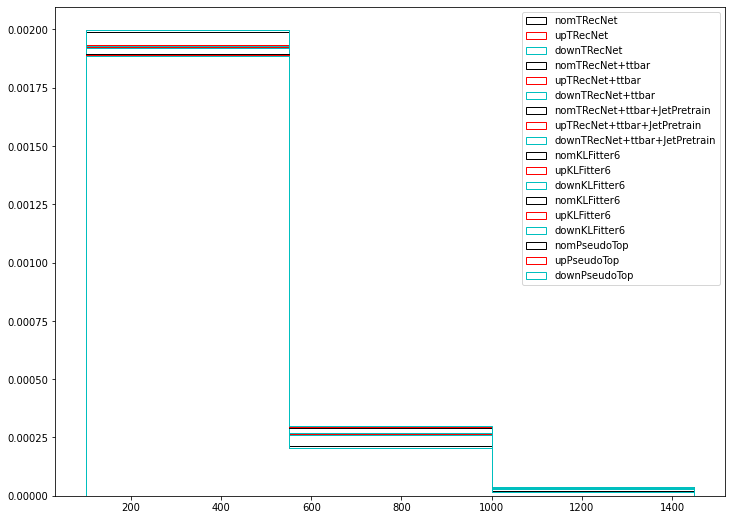

In [126]:
nbins=3
mmin = 100
mmax = 1450
ran = (mmin,mmax)


for ds in datasets[:-2]:

    print('For '+ds.reco_method+' with '+ds.cuts+'('+str(ds.perc_events)+'%)')

    plt.figure('Density',figsize=(12,9))
    den = True
    reco_n, bins, _ = plt.hist(ds.df['reco_th_E'],bins=nbins,range=ran,histtype='step',density=den,label='nom'+ds.reco_method,color='k')
    sysUP_n, _, _ = plt.hist(ds.sysUP_df['sysUP_th_E'],bins=nbins,range=ran,histtype='step',density=den,label='up'+ds.reco_method,color='r')
    sysDOWN_n, _, _ = plt.hist(ds.sysDOWN_df['sysDOWN_th_E'],bins=nbins,range=ran,histtype='step',density=den,label='down'+ds.reco_method,color='c')
    #plt.legend()
    #plt.show()
    #plt.close()
    print('Nominal:',[round(i,sigfigs=3) for i in reco_n])
    print('Up:',[round(i,sigfigs=3) for i in sysUP_n])
    print('Down:',[round(i,sigfigs=3) for i in sysDOWN_n])
    print('Frac Up:',100*sysUP_n/reco_n-100)
    print('Frac Down:',100-100*sysDOWN_n/reco_n)
    print('\n')

plt.legend()
plt.show()

[ 0.42689866 -2.13972111 -4.92274883]
[ 0.00426899 -0.02139721 -0.04922749]


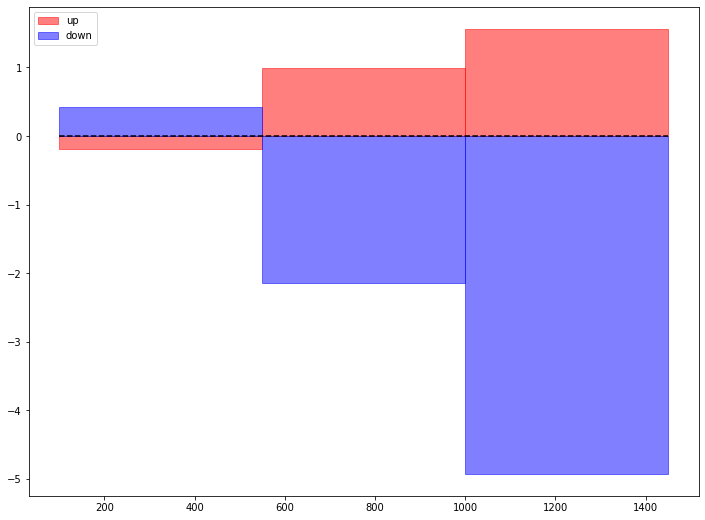

In [125]:
sysUP_results = np.array([100*(up-nom)/nom for up,nom in zip(sysUP_n,reco_n)])
sysDOWN_results = np.array([100*(nom-down)/nom for down,nom in zip(sysDOWN_n,reco_n)])

print(sysDOWN_results)
print(1-sysDOWN_n/reco_n)

bin_width = bins[1]-bins[0]
bin_width = np.diff(bins)
plt.figure('Sys_Hist',figsize=(12,9))
#plt.plot(bins[:-1]+bin_width/2,sysUP_results,'ko',label='up')
#plt.plot(bins[:-1]+bin_width/2,sysDOWN_results,'bo',label='down')
x_dash, y_dash = np.linspace(mmin,mmax,nbins),[0]*nbins
plt.plot(x_dash,y_dash,'k--')
plt.bar(x=bins[:-1],height=sysUP_results,width=np.diff(bins),align='edge',fill=True,linewidth=1,color='r',edgecolor='r',alpha=0.5,zorder=-1,label='up')
plt.bar(x=bins[:-1],height=sysDOWN_results,width=np.diff(bins),align='edge',fill=True,linewidth=1,color='b',edgecolor='b',alpha=0.5,zorder=-1,label='down')
plt.legend()

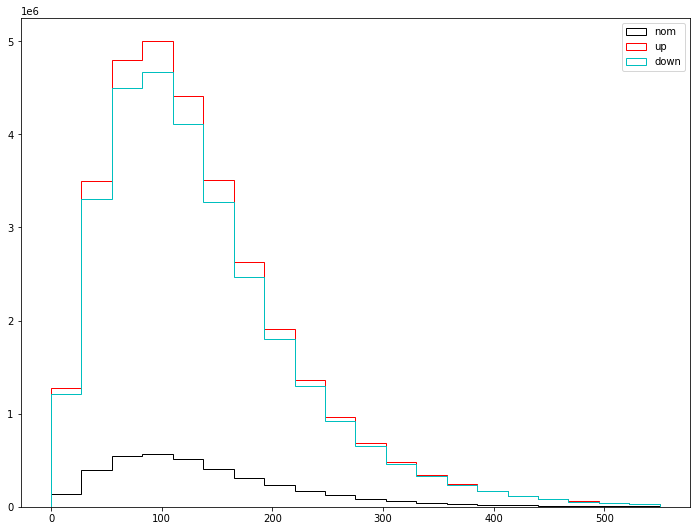

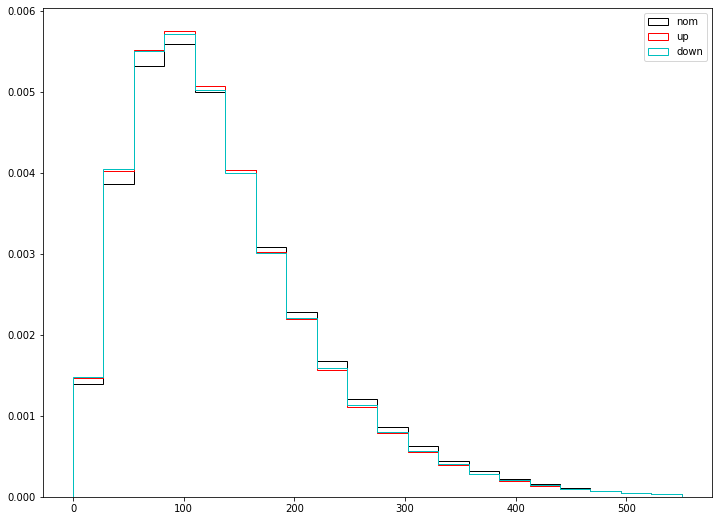

In [52]:
nbins=20
ran = (0,550)

plt.figure('No Density',figsize=(12,9))
den = False
reco_n, bins, _ = plt.hist(dataset.df['reco_th_pt'],bins=nbins,range=ran,histtype='step',density=den,label='nom',color='k')
sysUP_n, _, _ = plt.hist(dataset.sysUP_df['sysUP_th_pt'],bins=nbins,range=ran,histtype='step',density=den,label='up',color='r')
sysDOWN_n, _, _ = plt.hist(dataset.sysDOWN_df['sysDOWN_th_pt'],bins=nbins,range=ran,histtype='step',density=den,label='down',color='c')
plt.legend()

plt.figure('Density',figsize=(12,9))
den=True
reco_n, bins, _ = plt.hist(dataset.df['reco_th_pt'],bins=nbins,range=ran,histtype='step',density=den,label='nom',color='k')
sysUP_n, _, _ = plt.hist(dataset.sysUP_df['sysUP_th_pt'],bins=nbins,range=ran,histtype='step',density=den,label='up',color='r')
sysDOWN_n, _, _ = plt.hist(dataset.sysDOWN_df['sysDOWN_th_pt'],bins=nbins,range=ran,histtype='step',density=den,label='down',color='c')
plt.legend()

plt.show()

In [53]:
print(len(dataset.df['reco_th_pt']))
print(len(dataset.sysUP_df['sysUP_th_pt']))
print(len(dataset.sysDOWN_df['sysDOWN_th_pt']))

3711917
31669064
29777805


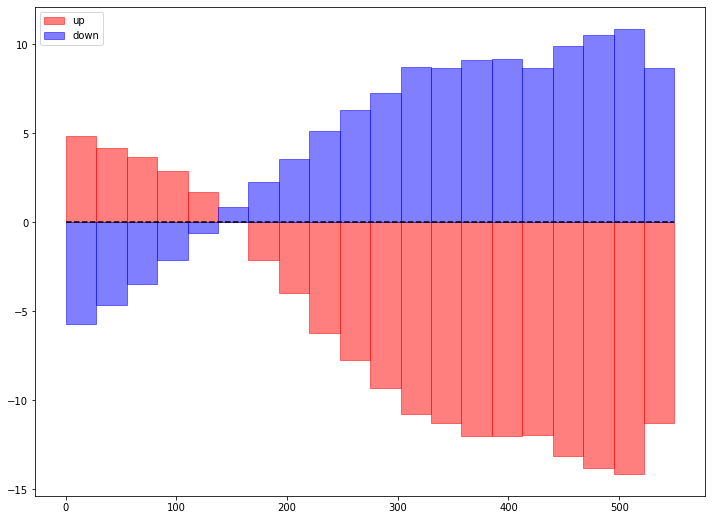

In [56]:
#sysUP_results = np.array([(up-nom)/nom for up,nom in zip(dup,dreco)])
#sysDOWN_results = np.array([(nom-down)/nom for down,nom in zip(ddown,dreco)])

#average = (sysUP_n+sysDOWN_n)/2
sysUP_results = np.array([100*(up-nom)/nom for up,nom in zip(sysUP_n,reco_n)])
sysDOWN_results = np.array([100*(nom-down)/nom for down,nom in zip(sysDOWN_n,reco_n)])

bin_width = bins[1]-bins[0]
plt.figure('Sys_Hist',figsize=(12,9))
#plt.plot(bins[:-1]+bin_width/2,sysUP_results,'ko',label='up')
#plt.plot(bins[:-1]+bin_width/2,sysDOWN_results,'bo',label='down')
x_dash, y_dash = np.linspace(0,550,nbins),[0]*nbins
plt.plot(x_dash,y_dash,'k--')
plt.bar(x=bins[:-1],height=sysUP_results,width=np.diff(bins),align='edge',fill=True,linewidth=1,color='r',edgecolor='r',alpha=0.5,zorder=-1,label='up')
plt.bar(x=bins[:-1],height=sysDOWN_results,width=np.diff(bins),align='edge',fill=True,linewidth=1,color='b',edgecolor='b',alpha=0.5,zorder=-1,label='down')
plt.legend()

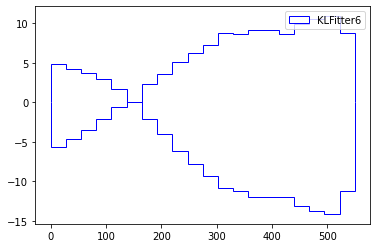

In [68]:
sysUP_results = np.array([100*(up-nom)/nom for up,nom in zip(sysUP_n,reco_n)])
sysDOWN_results = np.array([100*(nom-down)/nom for down,nom in zip(sysDOWN_n,reco_n)])

pos_weights = np.array([up if up>0 else down if down>0 else 0 for up, down in zip(sysUP_results,sysDOWN_results)])
neg_weights = np.array([up if up<0 else down if down<0 else 0 for up, down in zip(sysUP_results,sysDOWN_results)])

plt.hist(bins[:-1], bins, weights=pos_weights, histtype='step', color='b', label=dataset.reco_method)
plt.hist(bins[:-1], bins, weights=neg_weights, histtype='step', color='b')
plt.legend()

(array([2., 1., 1., 1.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 [<matplotlib.patches.Polygon at 0x7fc49a8ce070>])

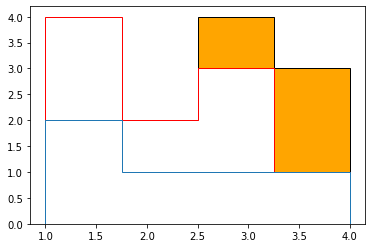

In [49]:
x1=[1,1,1,1,2,2,3,3,3,4]
x2=[1,2,2,3,3,3,3,4,4,4]

n_dn,b_dn,p_dn = plt.hist(x2,histtype='stepfilled',bins=4,range=(1,4),color='orange',ec='black')
n_up,b_up,p_up = plt.hist(x1,histtype='stepfilled',bins=4,range=(1,4),color='white',ec='red')
plt.hist([1,1,2,3,4],histtype='step',bins=4,range=(1,4))

# print(n_up)
# print(n_dn)
# print(b_up[:-1])

# plt.fill_between(b_up[:-1],n_dn,n_up,alpha=0.5)
# #plt.bar(x=b_up[:-1],height=np.abs(n_up-n_dn),width=np.diff(b_up), align='edge')




In [53]:
# Trees for dR < 0.4 cut matching
# with uproot.open('/data/jchishol/mc16e/mntuple_ttbar_0_parton_ejets_fixed+match0d4_new.root') as og_file:
#     reco_tree04 = og_file['reco'].arrays()
#     parton_tree04 = og_file['parton'].arrays()

# # Trees for dR < 0.6 cut matching
# with uproot.open('/data/jchishol/mc16e/mntuple_ttbar_0_parton_ejets_fixed+match0d6_new.root') as og_file:
#     reco_tree06 = og_file['reco'].arrays()
#     parton_tree06 = og_file['parton'].arrays()


with uproot.open('/mnt/xrootdg/jchishol/mntuples_08_01_22/mc16a_4j/mntuple_ljets_5_jetMatch04.root') as og_file:
    nom_tree = og_file['nominal'].arrays()

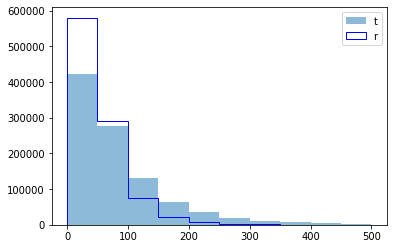

In [75]:
plt.hist(nom_tree['MC_ttbar_afterFSR_pt']/1000,range=(0,500),histtype='stepfilled',label='t',alpha=0.5)
plt.hist(nom_tree['klfitter_bestPerm_ttbar_pt'],range=(0,500),histtype='step',label='r',color='white',ec='blue')
plt.legend()


In [60]:
from Plotter import Variable, Particle, Plot, Dataset

In [3]:
# Define all the variables and their ranges we want
scale = '[GeV]'
pt = Variable('pt', 'p_T', np.arange(0,500,50), unit=scale)
eta = Variable('eta', '\eta', np.arange(-6,7.5,1.5))
y = Variable('y', 'y', np.arange(-2.5,3,0.5))
phi = Variable('phi', '\phi', np.arange(-3,3.75,0.75))
m_t = Variable('m','m', np.arange(100,260,20), unit=scale)
E_t = Variable('E','E', np.arange(100,1000,100), unit=scale)
#pout_t = Variable('pout','p_{out}',range(-275,325,50), unit=scale,alt_names=['Pout'])
m_tt = Variable('m','m', np.arange(200,1100,100), unit=scale)
E_tt = Variable('E','E', np.arange(200,2200,200), unit=scale)
dphi_tt = Variable('dphi','\Delta\phi', np.arange(0,4,0.5),alt_names=['deltaPhi'])
Ht_tt = Variable('Ht','H_T',np.arange(0,1100,100),unit=scale,alt_names=['HT'])
yboost_tt = Variable('yboost','y_{boost}',np.arange(-3,3.5,0.75),alt_names=['y_boost'])
#ystar_tt = Variable('ystar','y_{star}',np.arange(-2.5,3,0.5),alt_names=['y_star'])
chi_tt = Variable('chi','\chi',np.arange(0,25,2.5),alt_names=['chi_tt'])

# Define the particles we want
top_had = Particle('th','t,had',[pt,eta,y,phi,m_t,E_t],alt_names=['thad','topHad','top_had'])
top_lep = Particle('tl','t,lep',[pt,eta,y,phi,m_t,E_t],alt_names=['tlep','topLep','top_lep'])
top_antitop = Particle('ttbar','t\overline{t}',[pt,eta,y,phi,m_tt,E_tt,dphi_tt,Ht_tt,yboost_tt,chi_tt])

In [4]:
# Open first root file and its trees
file0 = uproot.open('/data/jchishol/mc1516_new/mntuple_ljets_01_jetMatch04.root')


# Create pandas dataframe

tree = file0['nominal'].arrays()
keys = file0['nominal'].keys()

# Did an met_met cut for the ML data, so let's match it here too
sel = tree['met_met']/1000 >= 20
tree = tree[sel]

# Note: some events did not have a logLikelihood calculated -- we will need to pad these events to make sure nothing gets shifted weird, and then cut them
df = ak.to_pandas(ak.fill_none(ak.pad_none(tree['klfitter_logLikelihood'],1),np.nan)) 
df.rename(columns={'values':'logLikelihood'},inplace=True)             # Rename first column appropriately
df.reset_index(level=1, drop=True,inplace=True)

# Add reco variables to be plotted
for par in [top_had,top_lep,top_antitop]:      # For each particle

    # Get all the possible names for this particle
    alt_par_names = list(par.alt_names)
    alt_par_names.append(par.name)

    for var in par.variables:                  # For each variable of that particle

        # Reset
        found_reco=False
        found_truth=False

        # Get all the possible names for this variable
        alt_var_names = list(var.alt_names)
        alt_var_names.append(var.name)

        for (par_name,var_name) in list(itertools.product(alt_par_names,alt_var_names)):
            if 'klfitter_bestPerm_'+par_name+'_'+var_name in keys:
                df['reco_'+par.name+'_'+var.name] = ak.to_pandas(tree['klfitter_bestPerm_'+par_name+'_'+var_name])      # Append the reco values
                found_reco=True
            if 'klfitter_bestPerm_'+var_name in keys: # (particularly, chi_tt)
                df['reco_'+par.name+'_'+var.name] = ak.to_pandas(tree['klfitter_bestPerm_'+var_name])      # Append the reco values
                found_reco=True
            if 'MC_'+par_name+'_afterFSR_'+var_name in keys:
                df['truth_'+par.name+'_'+var.name] = ak.to_pandas(tree['MC_'+par_name+'_afterFSR_'+var_name])    # Append the true values
                found_truth=True
            if 'MC_'+var_name in keys:  # (particularly, chi_tt)
                df['truth_'+par.name+'_'+var.name] = ak.to_pandas(tree['MC_'+var_name])
                found_truth = True
            # if 'MC_'+par_name+var_name in keys: # (in particular, for Pout)
            #     df['truth_'+par.name+'_'+var.name] = ak.to_pandas(tree['MC_'+par_name+var_name])    # Append the true values
            #     found_truth=True

            # Stop looking for the correct names once we find them
            if found_reco and found_truth:
                break

# Drop those events where klfitter log likelihood couldn't be calculated
df = df.dropna()

for level in ['truth','reco']:

    # ttbar Ht
    df[level+'_ttbar_Ht'] = df[level+'_th_pt']+df[level+'_tl_pt']

    # ttbar dphi
    th_vec = vector.arr({"pt": df[level+'_th_pt'], "phi": df[level+'_th_phi'], "eta": df[level+'_th_eta'],"mass": df[level+'_th_m']})
    tl_vec = vector.arr({"pt": df[level+'_tl_pt'], "phi": df[level+'_tl_phi'], "eta": df[level+'_tl_eta'],"mass": df[level+'_tl_m']}) 
    df[level+'_ttbar_dphi'] = abs(th_vec.deltaphi(tl_vec))

    # ttbar yboost and ystar
    df[level+'_ttbar_yboost'] = 0.5*(df[level+'_th_y']+df[level+'_tl_y'])
    #df[level+'_ttbar_ystar'] = 0.5*(df[level+'_th_y']-df[level+'_tl_y'])

for par in [top_had,top_lep,top_antitop]:           # For each particle
    for var in par.variables:    # For each variable of that particle
    
        # Convert from MeV to GeV for some truth values
        if var.name in ['pt','m','E','pout','Ht']:  
            df['truth_'+par.name+'_'+var.name] = df['truth_'+par.name+'_'+var.name]/1000

print(df)

       logLikelihood  truth_th_pt  reco_th_pt  truth_th_eta  reco_th_eta  \
entry                                                                      
0         -62.613747   285.239685  274.562805     -0.412410     0.859794   
1         -44.232487   118.037613   82.683647      0.331716     0.857541   
2         -63.099541   123.360909  134.706146      0.234600    -1.060789   
3         -54.928734    44.995213   87.198532      2.851338     1.683824   
4         -45.096287    81.959869   57.753456      0.002967    -0.181185   
...              ...          ...         ...           ...          ...   
67572     -45.371948   110.561775   99.016541      0.162650     0.198588   
67573     -61.264763   296.726715  119.532249      1.662143     3.050027   
67574     -55.605442   162.887848  165.905212      2.010991     2.126416   
67575     -65.133972   349.271027  128.007477      2.020694     3.243264   
67576     -46.909729   249.972794  300.658478      1.087862     1.026124   

       trut

In [5]:
new_df = df
for i in ['02','03','04','05','06','07','08','09','10','11']:

    # Open first root file and its trees
    file0 = uproot.open('/data/jchishol/mc1516_new/mntuple_ljets_'+i+'_jetMatch04.root')


    # Create pandas dataframe

    tree = file0['nominal'].arrays()
    keys = file0['nominal'].keys()

    df = ak.to_pandas(tree['klfitter_logLikelihood']) 
    df.rename(columns={'values':'logLikelihood'},inplace=True)             # Rename first column appropriately
    df.reset_index(level=1, drop=True,inplace=True)

    # Add reco variables to be plotted
    for par in [top_had,top_lep,top_antitop]:      # For each particle

        # Get all the possible names for this particle
        alt_par_names = list(par.alt_names)
        alt_par_names.append(par.name)

        for var in par.variables:                  # For each variable of that particle

            # Reset
            found_reco=False
            found_truth=False

            # Get all the possible names for this variable
            alt_var_names = list(var.alt_names)
            alt_var_names.append(var.name)

            for (par_name,var_name) in list(itertools.product(alt_par_names,alt_var_names)):
                if 'klfitter_bestPerm_'+par_name+'_'+var_name in keys:
                    df['reco_'+par.name+'_'+var.name] = ak.to_pandas(tree['klfitter_bestPerm_'+par_name+'_'+var_name])      # Append the reco values
                    found_reco=True
                if 'klfitter_bestPerm_'+var_name in keys: # (particularly, chi_tt)
                    df['reco_'+par.name+'_'+var.name] = ak.to_pandas(tree['klfitter_bestPerm_'+var_name])      # Append the reco values
                    found_reco=True
                if 'MC_'+par_name+'_afterFSR_'+var_name in keys:
                    df['truth_'+par.name+'_'+var.name] = ak.to_pandas(tree['MC_'+par_name+'_afterFSR_'+var_name])    # Append the true values
                    found_truth=True
                if 'MC_'+var_name in keys:  # (particularly, chi_tt)
                    df['truth_'+par.name+'_'+var.name] = ak.to_pandas(tree['MC_'+var_name])
                    found_truth = True
                # if 'MC_'+par_name+var_name in keys: # (in particular, for Pout)
                #     df['truth_'+par.name+'_'+var.name] = ak.to_pandas(tree['MC_'+par_name+var_name])    # Append the true values
                #     found_truth=True

                # Stop looking for the correct names once we find them
                if found_reco and found_truth:
                    break

    for level in ['truth','reco']:

        # ttbar Ht
        df[level+'_ttbar_Ht'] = df[level+'_th_pt']+df[level+'_tl_pt']

        # ttbar dphi
        th_vec = vector.arr({"pt": df[level+'_th_pt'], "phi": df[level+'_th_phi'], "eta": df[level+'_th_eta'],"mass": df[level+'_th_m']})
        tl_vec = vector.arr({"pt": df[level+'_tl_pt'], "phi": df[level+'_tl_phi'], "eta": df[level+'_tl_eta'],"mass": df[level+'_tl_m']}) 
        df[level+'_ttbar_dphi'] = abs(th_vec.deltaphi(tl_vec))

        # ttbar yboost and ystar
        df[level+'_ttbar_yboost'] = 0.5*(df[level+'_th_y']+df[level+'_tl_y'])
        #df[level+'_ttbar_ystar'] = 0.5*(df[level+'_th_y']-df[level+'_tl_y'])

    for par in [top_had,top_lep,top_antitop]:           # For each particle
        for var in par.variables:    # For each variable of that particle
        
            # Convert from MeV to GeV for some truth values
            if var.name in ['pt','m','E','pout','Ht']:  
                df['truth_'+par.name+'_'+var.name] = df['truth_'+par.name+'_'+var.name]/1000


    new_df = pd.concat([new_df,df],axis=0,ignore_index=True)


print(new_df)
    

         logLikelihood  truth_th_pt  reco_th_pt  truth_th_eta  reco_th_eta  \
0           -62.613747   285.239685  274.562805     -0.412410     0.859794   
1           -44.232487   118.037613   82.683647      0.331716     0.857541   
2           -63.099541   123.360909  134.706146      0.234600    -1.060789   
3           -54.928734    44.995213   87.198532      2.851338     1.683824   
4           -45.096287    81.959869   57.753456      0.002967    -0.181185   
...                ...          ...         ...           ...          ...   
7297337     -43.923218   232.905594  220.614853      0.823578     0.870250   
7297338     -60.161686   141.205902  106.625519     -1.770418    -1.568926   
7297339     -46.588768   112.763306   21.474077     -0.529325    -2.556788   
7297340     -66.897110   304.542511   33.357075     -1.566077    -4.626599   
7297341     -47.082821   123.513588   73.860817      1.121956     1.044984   

         truth_th_y  reco_th_y  truth_th_phi  reco_th_phi  trut

In [6]:
df = new_df

df['ttbar_pt_res'] = (df['reco_ttbar_pt'] - df['truth_ttbar_pt'])/df['truth_ttbar_pt']

cut_df = df[df['logLikelihood']>-52]

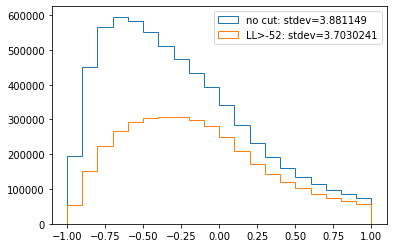

In [9]:
plt.hist(df['ttbar_pt_res'],range=(-1,1),bins=20,histtype='step',label='no cut: stdev='+str(df['ttbar_pt_res'].std()),density=False)
plt.hist(cut_df['ttbar_pt_res'],range=(-1,1),bins=20,histtype='step',label='LL>-52: stdev='+str(cut_df['ttbar_pt_res'].std()),density=False)
plt.legend()
plt.show()

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


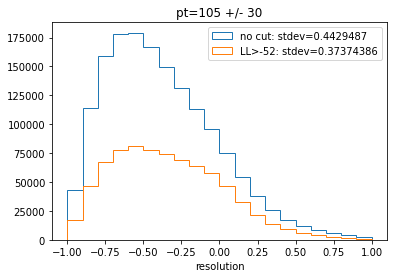

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


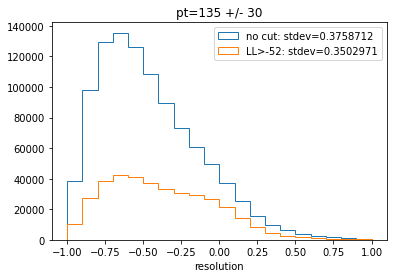

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


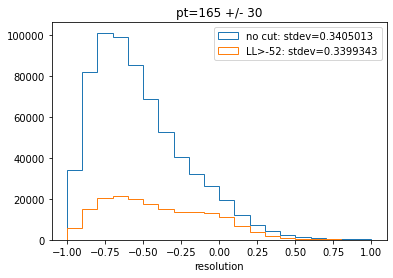

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


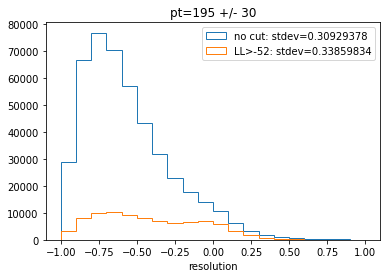

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


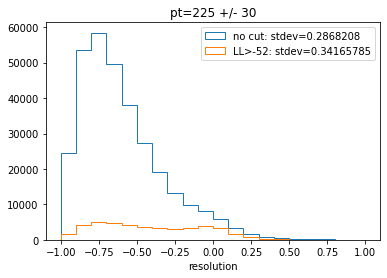

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


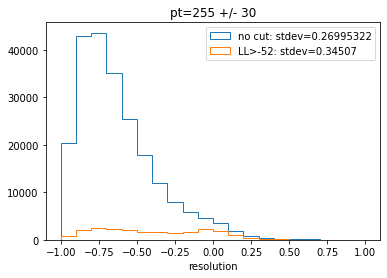

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


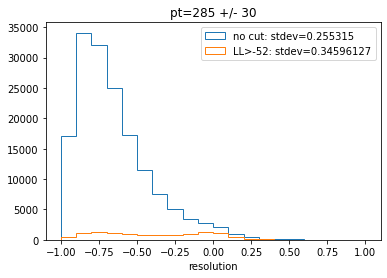

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


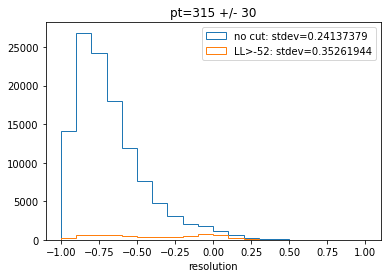

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


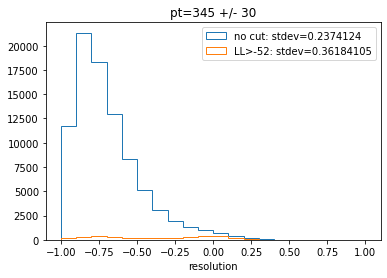

/tmp/ipykernel_577335/849659070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
/tmp/ipykernel_577335/849659070.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]


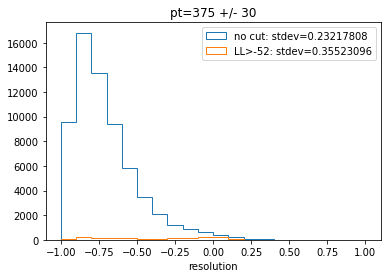

In [8]:
for pt in [105,135,165,195,225,255,285,315,345,375]:
    temp_df = df[df['truth_ttbar_pt']<pt+30][df['truth_ttbar_pt']>=pt-30]
    temp_cut_df = cut_df[cut_df['truth_ttbar_pt']<pt+30][cut_df['truth_ttbar_pt']>=pt-30]
    plt.hist(temp_df['ttbar_pt_res'],range=(-1,1),bins=20,histtype='step',label='no cut: stdev='+str(temp_df['ttbar_pt_res'].std()),density=False)
    plt.hist(temp_cut_df['ttbar_pt_res'],range=(-1,1),bins=20,histtype='step',label='LL>-52: stdev='+str(temp_cut_df['ttbar_pt_res'].std()),density=False)
    plt.legend()
    plt.title('pt='+str(pt)+' +/- 30')
    plt.xlabel('resolution')
    plt.show()

In [17]:
# Cut on log-likelihood (if desired)
df[['reco_ttbar_pt','truth_ttbar_pt','ttbar_pt_res']][df['ttbar_pt_res']<-0.99]

,reco_ttbar_pt,truth_ttbar_pt,ttbar_pt_res
3930,4.049991,561.671631,-0.992789
9092,0.257899,72.798698,-0.996457
9470,0.680678,136.896896,-0.995028
11807,4.091174,434.599365,-0.990586
22065,2.855190,317.659454,-0.991012
...,...,...,...
7276840,1.588359,214.288010,-0.992588
7279178,1.344564,577.507080,-0.997672
7282849,2.583744,381.186157,-0.993222
7284517,3.181655,540.770813,-0.994116


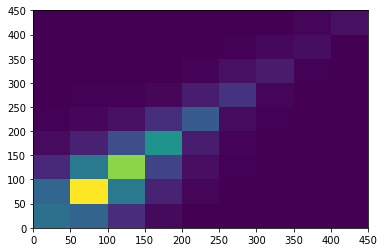

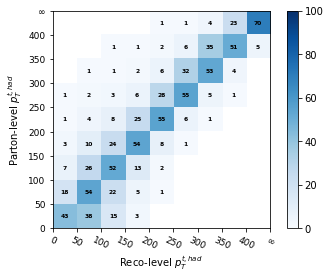

In [10]:


# Define a useful string
name ='th_pt'

# Define useful constants
tk = pt.ticks
tkls = pt.tick_labels
n = len(tk)
ran = tk[::n-1]


# Create 2D array of truth vs reco variable (which can be plotted also)
H, _, _, _ = plt.hist2d(np.clip(cut_df['truth_th_pt'],tk[0],tk[-1]),np.clip(cut_df['reco_th_pt'],tk[0],tk[-1]),bins=tk,range=[ran,ran])

# Normalize across rows (if desired)
if True:
    H = (H/np.sum(H,axis=0))*100
        
    # Round to integers (and transpose, so it's where we need it for plotting later)
    cm = np.rint(H).T.astype(int)

    # Plot truth vs reco pt with normalized rowsx
    plt.figure(' Normalized 2D Plot')
    masked_cm = np.ma.masked_where(cm==0,cm)  # Needed to make the zero bins white
    plt.imshow(masked_cm,extent=[0,n-1,0,n-1],cmap=plt.cm.Blues,origin='lower')
    plt.xticks(np.arange(n),tkls,fontsize=9,rotation=-25)
    plt.yticks(np.arange(n),tkls,fontsize=9)
    plt.xlabel('Reco-level '+top_had.labels[pt.name])
    plt.ylabel('Parton-level '+top_had.labels[pt.name])
    if True: plt.clim(0,100)
    plt.colorbar()

    # Label the content of each bin
    for j in range (n-1):
        for k in range(n-1):
            if masked_cm.T[j,k] != 0:   # Don't label empty bins
                plt.text(j+0.5,k+0.5,masked_cm.T[j,k],color='k',fontsize=6,weight="bold",ha="center",va="center")

plt.savefig('p.png')
plt.show()




Saved Figure: ./KLFitter(LL>-52)_Confusion_Matrix_e+mjets_th_pt


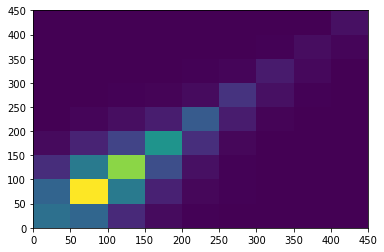

In [20]:
Plot.Confusion_Matrix(Dataset(new_df,'KLFitter','e+mjets'),top_had,pt,norm=True,LL_cut=-52)

In [28]:
# Matching info for dR < 0.4 cut
# match_data04 = np.array(np.load('/data/jchishol/mc16e/matching_info/matching_info_0_parton_ejets0d4_new.npy'))
# event_indices04 = match_data04[:,0].astype(int)
# best_jets04 = match_data04[:,1].astype(int)
# matched_pars04 = match_data04[:,2]
# dRs04 = match_data04[:,3].astype(float)
# frac_delta_pts04 = match_data04[:,4].astype(float)
# num_events04 = len(parton_tree04['eventNumber'])
# num_matched04 = len(dRs04)

# print('For new dR<0.4 matching:')
# print('--------------------')
# print('Total number of events: ', num_events04)
# print('Number of matched pairs: ', num_matched04)
# print('Percentage of matches with dR<0.4: %f%%' % (100*num_matched04/(4*num_events04)))
# print('Percentage of these successful matches (i.e. dR < 0.4) that have frac pt > -1: %f%%' % (100*len(frac_delta_pts04[frac_delta_pts04>-1])/num_matched04))
# print('Percentage of matches with dR<0.4 AND fractional $\Delta p_T$ > -1: %f%%' % (100*len(frac_delta_pts04[frac_delta_pts04>-1])/(4*num_events04)))
# print('Percentage of matches with dR<0.4 AND fractional $\Delta p_T$ < -1: %f%%\n' % (100*len(frac_delta_pts04[frac_delta_pts04<-1])/(4*num_events04)))


# # Matching info for dR < 0.46cut
# match_data06 = np.array(np.load('/data/jchishol/mc16e/matching_info/matching_info_0_parton_ejets0d6.npy'))
# event_indices06 = match_data06[:,0].astype(int)
# best_jets06 = match_data06[:,1].astype(int)
# matched_pars06 = match_data06[:,2]
# dRs06 = match_data06[:,3].astype(float)
# frac_delta_pts06 = match_data06[:,4].astype(float)
# num_events06 = len(parton_tree06['eventNumber'])
# num_matched06 = len(dRs06)

# print('For new dR<0.6 matching:')
# print('--------------------')
# print('Total number of events: ', num_events06)
# print('Number of matched pairs: ', num_matched06)
# print('Percentage of matches with dR<0.6: %f%%' % (100*num_matched06/(4*num_events06)))
# print('Percentage of these successful matches (i.e. dR < 0.6) that have frac pt > -1: %f%%' % (100*len(frac_delta_pts06[frac_delta_pts06>-1])/num_matched06))
# print('Percentage of matches with dR<0.6 AND fractional $\Delta p_T$ > -1: %f%%' % (100*len(frac_delta_pts06[frac_delta_pts06>-1])/(4*num_events06)))
# print('Percentage of matches with dR<0.6 AND fractional $\Delta p_T$ < -1: %f%%\n' % (100*len(frac_delta_pts06[frac_delta_pts06<-1])/(4*num_events06)))



# Matching info for new dR < 0.4 cut
match_data04 = np.array(np.load('/data/jchishol/mc1516_new/matching_info/matching_info_mntuple_ljets_05_jetMatch04.npy'))
event_indices04 = match_data04[:,0].astype(int)
matched_pars04 = match_data04[:,1]
best_jets04 = match_data04[:,2].astype(int)
best_quarks04 = match_data04[:,3].astype(int)
dRs04 = match_data04[:,4].astype(float)
frac_delta_pts04 = match_data04[:,5].astype(float)
num_events04 = len(nom_tree['eventNumber'])
num_matched04 = len(dRs04)


print('For new dR<0.4 matching:')
print('--------------------')
print('Total number of events: ', num_events04)
print('Number of matched pairs: ', num_matched04)
print('Percentage of matches with dR<0.4: %f%%' % (100*num_matched04/(4*num_events04)))
print('Percentage of these successful matches (i.e. dR < 0.4) that have frac pt > -1: %f%%' % (100*len(frac_delta_pts04[frac_delta_pts04>-1])/num_matched04))
print('Percentage of matches with dR<0.4 AND fractional $\Delta p_T$ > -1: %f%%' % (100*len(frac_delta_pts04[frac_delta_pts04>-1])/(4*num_events04)))
print('Percentage of matches with dR<0.4 AND fractional $\Delta p_T$ < -1: %f%%\n' % (100*len(frac_delta_pts04[frac_delta_pts04<-1])/(4*num_events04)))

hello
[['0' 'b_from_thad' '3' '5' '0.16305398468389243' '0.14924280163395437']
 ['0' 'b_from_tlep' '1' '5' '0.09748300785563324' '0.12458928657056526']
 ['0' 'Wdecay1_from_thad' '2' '3' '0.05495748855708394'
  '0.1976284468305962']
 ...
 ['981009' 'b_from_thad' '3' '5' '0.017625695056231065'
  '0.053510154694444735']
 ['981009' 'b_from_tlep' '1' '5' '0.019853151295494784'
  '0.06433950273863867']
 ['981009' 'Wdecay1_from_thad' '4' '1' '0.03302693277796143'
  '-0.2689318825303864']]
For new dR<0.4 matching:
--------------------
Total number of events:  981010
Number of matched pairs:  3363471
Percentage of matches with dR<0.4: 85.714493%
Percentage of these successful matches (i.e. dR < 0.4) that have frac pt > -1: 99.840135%
Percentage of matches with dR<0.4 AND fractional $\Delta p_T$ > -1: 85.577466%
Percentage of matches with dR<0.4 AND fractional $\Delta p_T$ < -1: 0.137027%



In [43]:
print(nom_tree['jet_isTruth'])
padded_matches = np.asarray(ak.fill_none(ak.pad_none(nom_tree['jet_isTruth'], 6, clip=True), 0))
print(padded_matches)

[[0, 1, 1, 1, 0, 1], [1, 1, 1, 0, 1], [1, ... 0], [1, 1, 1, 0], [0, 1, 0, 1, 1, 0]]
[[0 1 1 1 0 1]
 [1 1 1 0 1 0]
 [1 1 1 1 0 0]
 ...
 [0 1 1 1 1 0]
 [1 1 1 0 0 0]
 [0 1 0 1 1 0]]


In [29]:
print((100*len(frac_delta_pts04[abs(frac_delta_pts04)<=0.5])/(num_matched04)))

96.8615457068011


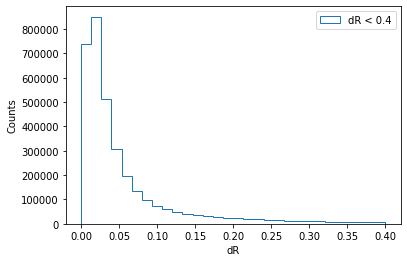

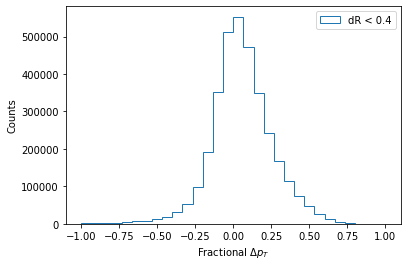

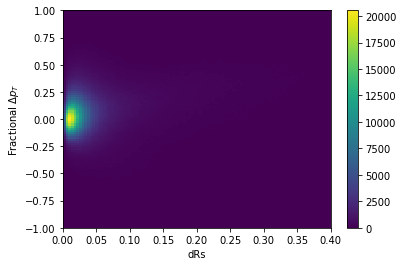

In [30]:
plt.figure('dR')
#plt.hist(dRs06,bins=30,range=(0,0.6),label='dR < 0.6',density=True,histtype='step')
plt.hist(dRs04,bins=30,range=(0,0.4),label='dR < 0.4',histtype='step')
plt.xlabel('dR')
plt.ylabel('Counts')
plt.legend()


plt.figure('frac_delta_pt')
#plt.hist(frac_delta_pts06,bins=30,range=(-1,1),label='dR < 0.6',density=True,histtype='step')
plt.hist(frac_delta_pts04,bins=30,range=(-1,1),label='dR < 0.4',histtype='step')
plt.xlabel('Fractional $\Delta p_T$')
plt.ylabel('Counts')
plt.legend()



plt.figure('2D')
plt.hist2d(dRs04,frac_delta_pts04,bins=(100,100),range=((0,0.4),(-1,1)))
plt.xlabel('dRs')
plt.ylabel('Fractional $\Delta p_T$')
plt.colorbar()


plt.show()

In [31]:
# dR < 0.4 dataframes
print('For dR < 0.4 matching:')
print('----------------------')
print('All data:')
df04 = pd.DataFrame({'Event':event_indices04, 'Parent': matched_pars04, 'Quark': best_quarks04, 'Jet':best_jets04, 'dR':dRs04.round(3), 'frac delta pt':frac_delta_pts04.round(3)})
#df_grouped04 = df04.groupby(['Event'], as_index=True).agg({'Jet': list,'Parent': list,'dR': list,'frac delta pt': list})
print(df04)
print('Not great matches:')
df04_bad = df04[df04['frac delta pt']<-1]
print(df04_bad)

# dR < 0.6 dataframes
# print('For dR < 0.6 matching:')
# print('----------------------')
# print('All data:')
# df06 = pd.DataFrame({'Event':event_indices06, 'Jet':best_jets06,'Parent': matched_pars06, 'dR':dRs06.round(3), 'frac delta pt':frac_delta_pts06.round(3)})
# #df_grouped06 = df06.groupby(['Event'], as_index=True).agg({'Jet': list,'Parent': list,'dR': list,'frac delta pt': list})
# print(df06)
# print('Not great matches:')
# df06_bad = df06[df06['frac delta pt']<-1]
# print(df06_bad)


For dR < 0.4 matching:
----------------------
All data:
          Event             Parent  Quark  Jet     dR  frac delta pt
0             0        b_from_thad      5    3  0.163          0.149
1             0        b_from_tlep      5    1  0.097          0.125
2             0  Wdecay1_from_thad      3    2  0.055          0.198
3             0  Wdecay2_from_thad      4    5  0.369          0.489
4             1        b_from_thad      5    2  0.074          0.343
5             1        b_from_tlep      5    1  0.025         -0.337
6             1  Wdecay1_from_thad      2    0  0.017          0.020
7             1  Wdecay2_from_thad      1    4  0.053          0.159
8             2        b_from_thad      5    0  0.027         -0.104
9             2        b_from_tlep      5    2  0.017         -0.071
10            2  Wdecay1_from_thad      1    3  0.035          0.027
11            2  Wdecay2_from_thad      2    1  0.042          0.196
12            3        b_from_thad      5    1 

In [32]:

print(nom_tree['jet_truthPartonLabel'])
print(nom_tree['MC_Wdecay1_from_thad_pdgId'])

qdf = pd.DataFrame(np.array(nom_tree['MC_Wdecay1_from_thad_pdgId']).astype(int),columns=['Wdecay1_pdgid'])
qdf['Wdecay2_pdgid'] = np.array(nom_tree['MC_Wdecay2_from_thad_pdgId']).astype(int)
qdf['jet_truth'] = list(nom_tree['jet_truthPartonLabel'])
qdf['Wdecay1_match'] = qdf.apply(lambda row: True if abs(row['Wdecay1_pdgid']) in row['jet_truth'] else False,axis=1)
qdf['Wdecay2_match'] = qdf.apply(lambda row: True if abs(row['Wdecay2_pdgid']) in row['jet_truth'] else False,axis=1)


print(qdf)

[[21, 5, 3, 5, 4, 4], [2, 5, 5, -1, 1], ... [2, 5, 5, 21], [21, 5, 2, 5, 1, 21]]
[3, 2, 1, 3, 2, 1, 4, 2, 3, 1, 3, 4, 1, 4, ... 3, 4, 1, 3, 4, 2, 3, 2, 2, 4, 1, 1, 1]
        Wdecay1_pdgid  Wdecay2_pdgid                     jet_truth  Wdecay1_match  Wdecay2_match
0                   3             -4           [21, 5, 3, 5, 4, 4]           True           True
1                   2             -1              [2, 5, 5, -1, 1]           True           True
2                   1             -2              [5, 2, 5, 1, 21]           True           True
3                   3             -4                  [5, 5, 3, 4]           True           True
4                   2             -1                  [1, 5, 2, 5]           True           True
5                   1             -2                  [2, 5, 5, 2]          False           True
6                   4             -3         [5, 4, 21, 21, 3, 21]           True           True
7                   2             -1  [1, 21, 5, 5, 21, 2

In [37]:

pd.options.display.max_rows = 50
pd.options.display.min_rows = 50
pd.options.display.width = 100
bad_df = qdf.query('Wdecay1_match ==False or Wdecay2_match==False')

bad_df['num'] = bad_df.apply(lambda row: sum(1 for i in np.array(row['jet_truth']).ravel() if i in range(1,5)),axis=1)
print(bad_df[bad_df['num']>=2])

        Wdecay1_pdgid  Wdecay2_pdgid                 jet_truth  Wdecay1_match  Wdecay2_match  num
5                   1             -2              [2, 5, 5, 2]          False           True    2
22                  3             -2          [2, 2, 5, 21, 5]          False           True    2
24                  3             -4          [5, 5, 4, 2, 21]          False           True    2
26                  1             -2           [2, 5, 5, 2, 2]          False           True    3
43                  3             -4              [5, 4, 5, 1]          False           True    2
47                  1             -2      [4, 21, 5, 2, 21, 5]          False           True    2
53                  4             -3              [5, 3, 3, 5]          False           True    2
68                  4             -3       [2, 21, 5, 5, 3, 3]          False           True    3
69                  4             -3          [4, 5, 5, 1, 21]           True          False    2
77                  

/tmp/ipykernel_1476539/1670255397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_df['num'] = bad_df.apply(lambda row: sum(1 for i in np.array(row['jet_truth']).ravel() if i in range(1,5)),axis=1)


In [38]:
print(bad_df)

        Wdecay1_pdgid  Wdecay2_pdgid                  jet_truth  Wdecay1_match  Wdecay2_match  num
5                   1             -2               [2, 5, 5, 2]          False           True    2
10                  3             -4              [5, 21, 5, 3]           True          False    1
12                  1             -2              [5, 5, 2, 21]          False           True    1
13                  4             -3          [21, 21, 5, 5, 3]          False           True    1
15                  3             -4              [21, 3, 5, 5]           True          False    1
19                  2             -1          [21, 2, 5, 5, 21]           True          False    1
22                  3             -2           [2, 2, 5, 21, 5]          False           True    2
24                  3             -4           [5, 5, 4, 2, 21]          False           True    2
26                  1             -2            [2, 5, 5, 2, 2]          False           True    3
29        

In [28]:
#df_grouped04 = df04.groupby(['Event'], as_index=False).agg({'Jet': list,'Parent': list,'dR': list,'frac delta pt': list})
#print(df_grouped04)

df_grouped04 = df04.groupby(['Event'], as_index=False).agg({'Parent': list,'Quark': list,'Jet': list,'dR': list,'frac delta pt': list})
print(df_grouped04)

       Event                                             Parent         Quark  \
0          0  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 3, 4]   
1          1  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 3, 4]   
2          2      [b_from_thad, b_from_tlep, Wdecay1_from_thad]     [5, 5, 2]   
3          3  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 4, 3]   
4          4      [b_from_thad, b_from_tlep, Wdecay1_from_thad]     [5, 5, 1]   
...      ...                                                ...           ...   
74629  74635  [b_from_thad, Wdecay1_from_thad, Wdecay2_from_...     [5, 1, 2]   
74630  74636  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 1, 2]   
74631  74637  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 1, 2]   
74632  74638  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 3, 4]   
74633  74639      [b_from_thad, b_from_tlep, Wdecay1_from_thad]     [5, 5, 3]   

                Jet        

       Event                                             Parent         Quark  \
0          0  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 3, 4]   
2          2      [b_from_thad, b_from_tlep, Wdecay1_from_thad]     [5, 5, 2]   
3          3  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 4, 3]   
4          4      [b_from_thad, b_from_tlep, Wdecay1_from_thad]     [5, 5, 1]   
5          5      [b_from_thad, b_from_tlep, Wdecay2_from_thad]     [5, 5, 2]   
...      ...                                                ...           ...   
74615  74621                         [b_from_thad, b_from_tlep]        [5, 5]   
74617  74623  [b_from_thad, b_from_tlep, Wdecay1_from_thad, ...  [5, 5, 3, 4]   
74622  74628                         [b_from_thad, b_from_tlep]        [5, 5]   
74629  74635  [b_from_thad, Wdecay1_from_thad, Wdecay2_from_...     [5, 1, 2]   
74633  74639      [b_from_thad, b_from_tlep, Wdecay1_from_thad]     [5, 5, 3]   

                Jet        

/tmp/ipykernel_1458593/307452428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notall['jet 0 pt'] = df_notall.apply(lambda row: nom_tree['jet_pt'][row['Event']][0],axis=1)


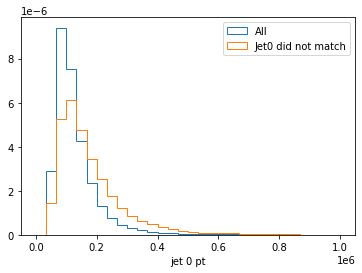

0.1989709783744674


In [38]:
df_grouped04['Jet 0 Matched'] = df_grouped04.apply(lambda row : True if 0 in row['Jet'] else False, axis=1)
df_notall = df_grouped04[df_grouped04['Jet 0 Matched']==False]
print(df_notall)

df_notall['jet 0 pt'] = df_notall.apply(lambda row: nom_tree['jet_pt'][row['Event']][0],axis=1)
print(df_notall['jet 0 pt'])

plt.hist(nom_tree['jet_pt'][:,0],bins=30,range=(0,1000000),histtype='step',density=True,label='All')
plt.hist(df_notall['jet 0 pt'],bins=30,range=(0,1000000),histtype='step',density=True,label = 'Jet0 did not match')
plt.xlabel('jet 0 pt')
plt.legend()
plt.show()

print(len(df_notall)/len(df_grouped04))

In [ ]:


# Calculate particle vectors
b_from_t_vec = vector.array({"pt":parton_tree06['MC_b_from_t_afterFSR_pt'],"eta":parton_tree06['MC_b_from_t_afterFSR_eta'],"phi":parton_tree06['MC_b_from_t_afterFSR_phi'],"E":parton_tree06['MC_b_from_t_afterFSR_E']})
b_from_tbar_vec = vector.array({"pt":parton_tree06['MC_b_from_tbar_afterFSR_pt'],"eta":parton_tree06['MC_b_from_tbar_afterFSR_eta'],"phi":parton_tree06['MC_b_from_tbar_afterFSR_phi'],"E":parton_tree06['MC_b_from_tbar_afterFSR_E']})
Wdecay1_from_t_vec = vector.array({"pt":parton_tree06['MC_Wdecay1_from_t_afterFSR_pt'],"eta":parton_tree06['MC_Wdecay1_from_t_afterFSR_eta'],"phi":parton_tree06['MC_Wdecay1_from_t_afterFSR_phi'],"E":parton_tree06['MC_Wdecay1_from_t_afterFSR_E']})
Wdecay2_from_t_vec = vector.array({"pt":parton_tree06['MC_Wdecay2_from_t_afterFSR_pt'],"eta":parton_tree06['MC_Wdecay2_from_t_afterFSR_y'],"phi":parton_tree06['MC_Wdecay2_from_t_afterFSR_phi'],"E":parton_tree06['MC_Wdecay2_from_t_afterFSR_E']})   # Approx eta with y for now, since eta empty
Wdecay1_from_tbar_vec = vector.array({"pt":parton_tree06['MC_Wdecay1_from_tbar_afterFSR_pt'],"eta":parton_tree06['MC_Wdecay1_from_tbar_afterFSR_eta'],"phi":parton_tree06['MC_Wdecay1_from_tbar_afterFSR_phi'],"E":parton_tree06['MC_Wdecay1_from_tbar_afterFSR_E']})
Wdecay2_from_tbar_vec = vector.array({"pt":parton_tree06['MC_Wdecay2_from_tbar_afterFSR_pt'],"eta":parton_tree06['MC_Wdecay2_from_tbar_afterFSR_eta'],"phi":parton_tree06['MC_Wdecay2_from_tbar_afterFSR_phi'],"E":parton_tree06['MC_Wdecay2_from_tbar_afterFSR_E']})

# Define some helpful ranges
had_range = list(range(1,9))+list(range(-8,0))                     # Quarks have pdgid 1 to 8 (negatives indicate antiparticles)
lep_range = list(range(11,19))+list(range(-18,10))                 # Leptons have pdgid 11 to 18
bos_range = list(range(21,26))+list(range(-25,20))+[9,37,-9,-37]   # Bosons have pdgid 21 to 25, and 9, and 37


for i in df_notall['Event']:

    print('-------------------------------')
    print('            Event '+str(i)+'            ')
    print('-------------------------------')



     # Calculate the jet vectors for this event, as well as get the btags
    jet_vectors = vector.array({"pt":reco_tree06['jet_pt'][i],"eta":reco_tree06['jet_eta'][i],"phi":reco_tree06['jet_phi'][i],"E":reco_tree06['jet_e'][i]})
    jet_btags = np.array(reco_tree04['jet_btagged'][i])

    particle_dict = {'b_from_t':{'dRs':jet_vectors.deltaR(b_from_t_vec[i]),'frac_delta_pts':((b_from_t_vec[i].pt - jet_vectors.pt)/b_from_t_vec[i].pt)},'b_from_tbar':{'dRs':jet_vectors.deltaR(b_from_tbar_vec[i]),'frac_delta_pts':((b_from_tbar_vec[i].pt - jet_vectors.pt)/b_from_tbar_vec[i].pt)}}
    if parton_tree04['MC_Wdecay1_from_t_afterFSR_pdgid'][i] in had_range or parton_tree04['MC_Wdecay2_from_t_afterFSR_pdgid'][i] in had_range:
        particle_dict['Wdecay1_from_t'] = {'dRs':jet_vectors.deltaR(Wdecay1_from_t_vec[i]),'frac_delta_pts':((Wdecay1_from_t_vec[i].pt - jet_vectors.pt)/Wdecay1_from_t_vec[i].pt)}
        particle_dict['Wdecay2_from_t'] = {'dRs':jet_vectors.deltaR(Wdecay2_from_t_vec[i]),'frac_delta_pts':((Wdecay2_from_t_vec[i].pt - jet_vectors.pt)/Wdecay2_from_t_vec[i].pt)}
    elif parton_tree04['MC_Wdecay1_from_tbar_afterFSR_pdgid'][i] in had_range or parton_tree04['MC_Wdecay2_from_tbar_afterFSR_pdgid'][i] in had_range:
        particle_dict['Wdecay1_from_tbar'] = {'dRs':jet_vectors.deltaR(Wdecay1_from_tbar_vec[i]),'frac_delta_pts':((Wdecay1_from_tbar_vec[i].pt - jet_vectors.pt)/Wdecay1_from_tbar_vec[i].pt)}
        particle_dict['Wdecay2_from_tbar'] = {'dRs':jet_vectors.deltaR(Wdecay2_from_tbar_vec[i]),'frac_delta_pts':((Wdecay2_from_tbar_vec[i].pt - jet_vectors.pt)/Wdecay2_from_tbar_vec[i].pt)}
    else:
        print('WARNING: none of the W decays in event %d seem to be jets! What?!' % i)
        print('pdgids: %d, %d, %d, %d' % (parton_tree04['MC_Wdecay1_from_t_afterFSR_pdgid'][i] ,parton_tree04['MC_Wdecay2_from_t_afterFSR_pdgid'][i] ,parton_tree04['MC_Wdecay1_from_tbar_afterFSR_pdgid'][i] ,parton_tree04['MC_Wdecay2_from_tbar_afterFSR_pdgid'][i] ))

    fig, axs = plt.subplots(2,2,figsize=(10,10))

    ax1 = [0,0,1,1]
    ax2 = [0,1,0,1]

    for a,par in enumerate(particle_dict):

        #if par not in df_notall[df_notall['Event']==i]['Parent'].to_list()[0]:

        dR_points_btag = []
        dR_points_nobtag = []
        pt_points_btag = []
        pt_points_nobtag = []

        for j in range(len(particle_dict[par]['dRs'])):
            if jet_btags[j]==1:
                dR_points_btag.append(particle_dict[par]['dRs'][j])
                pt_points_btag.append(particle_dict[par]['frac_delta_pts'][j])
            elif jet_btags[j]==0:
                dR_points_nobtag.append(particle_dict[par]['dRs'][j])
                pt_points_nobtag.append(particle_dict[par]['frac_delta_pts'][j])

        #plt.figure(par+' '+str(i))
        axs[ax1[a],ax2[a]].set_title(par+' '+str(i))

        rect1 = matplotlib.patches.Rectangle((0,-1), 0.6, 2, color='green',alpha=0.5,label='target region')
        axs[ax1[a],ax2[a]].add_patch(rect1)  # gca = 'grab current axis

        if par in df_notall[df_notall['Event']==i]['Parent'].to_list()[0]:
            index = df_notall[df_notall['Event']==i]['Parent'].to_list()[0].index(par)
            temp_df = df_notall[df_notall['Event']==i]
            axs[ax1[a],ax2[a]].plot([temp_df['dR'].to_list()[0][index]],[temp_df['frac delta pt'].to_list()[0][index]],'y*',markersize=15,label='chosen')
            del temp_df

        axs[ax1[a],ax2[a]].plot([particle_dict[par]['dRs'][0]],[particle_dict[par]['frac_delta_pts'][0]],'c*',markersize=15,label='leading jet')
        axs[ax1[a],ax2[a]].plot(dR_points_btag,pt_points_btag,'ro',label='btag')
        axs[ax1[a],ax2[a]].plot(dR_points_nobtag,pt_points_nobtag,'bo',label='no btag')


        axs[ax1[a],ax2[a]].legend()
        axs[ax1[a],ax2[a]].set_xlabel('dR')
        axs[ax1[a],ax2[a]].set_ylabel('frac delta pt')

        print(par+' pt=',parton_tree04['MC_'+par+'_afterFSR_pt'][i])
        print(par+' phi=',parton_tree04['MC_'+par+'_afterFSR_phi'][i])
        print(par+' eta=',parton_tree04['MC_'+par+'_afterFSR_eta'][i])

    print('Jet pts=',reco_tree04['jet_pt'][i])
    print('Jet phis=',reco_tree04['jet_phi'][i])
    print('Jet etas=',reco_tree04['jet_eta'][i])
    print('Jet btags=',jet_btags)

    #fig.show()

    if i > 100: break
        

    

In [ ]:
# Calculate particle vectors
b_from_t_vec = vector.array({"pt":parton_tree04['MC_b_from_t_afterFSR_pt'],"eta":parton_tree04['MC_b_from_t_afterFSR_eta'],"phi":parton_tree04['MC_b_from_t_afterFSR_phi'],"E":parton_tree04['MC_b_from_t_afterFSR_E']})
b_from_tbar_vec = vector.array({"pt":parton_tree04['MC_b_from_tbar_afterFSR_pt'],"eta":parton_tree04['MC_b_from_tbar_afterFSR_eta'],"phi":parton_tree04['MC_b_from_tbar_afterFSR_phi'],"E":parton_tree04['MC_b_from_tbar_afterFSR_E']})
Wdecay1_from_t_vec = vector.array({"pt":parton_tree04['MC_Wdecay1_from_t_afterFSR_pt'],"eta":parton_tree04['MC_Wdecay1_from_t_afterFSR_eta'],"phi":parton_tree04['MC_Wdecay1_from_t_afterFSR_phi'],"E":parton_tree04['MC_Wdecay1_from_t_afterFSR_E']})
Wdecay2_from_t_vec = vector.array({"pt":parton_tree04['MC_Wdecay2_from_t_afterFSR_pt'],"eta":parton_tree04['MC_Wdecay2_from_t_afterFSR_y'],"phi":parton_tree04['MC_Wdecay2_from_t_afterFSR_phi'],"E":parton_tree04['MC_Wdecay2_from_t_afterFSR_E']})   # Approx eta with y for now, since eta empty
Wdecay1_from_tbar_vec = vector.array({"pt":parton_tree04['MC_Wdecay1_from_tbar_afterFSR_pt'],"eta":parton_tree04['MC_Wdecay1_from_tbar_afterFSR_eta'],"phi":parton_tree04['MC_Wdecay1_from_tbar_afterFSR_phi'],"E":parton_tree04['MC_Wdecay1_from_tbar_afterFSR_E']})
Wdecay2_from_tbar_vec = vector.array({"pt":parton_tree04['MC_Wdecay2_from_tbar_afterFSR_pt'],"eta":parton_tree04['MC_Wdecay2_from_tbar_afterFSR_eta'],"phi":parton_tree04['MC_Wdecay2_from_tbar_afterFSR_phi'],"E":parton_tree04['MC_Wdecay2_from_tbar_afterFSR_E']})


for i,event in enumerate(list(df04_bad['Event'])):

    dR_points_btag = []
    dR_points_nobtag = []
    pt_points_btag = []
    pt_points_nobtag = []

    min_dR = 100000
    and_the_pt = 0

    plot = True


    par = list(df04_bad['Parent'])[i]

    if par=='b_from_t':
        par_vec=b_from_t_vec[event]
    elif par=='b_from_tbar':
        par_vec=b_from_tbar_vec[event]
    elif par=='Wdecay1_from_t':
        continue
        par_vec=Wdecay1_from_t_vec[event]
    elif par=='Wdecay2_from_t':
        continue
        par_vec=Wdecay2_from_t_vec[event]
    elif par=='Wdecay1_from_tbar':
        continue
        par_vec=Wdecay1_from_tbar_vec[event]
    elif par=='Wdecay2_from_tbar':
        continue
        par_vec=Wdecay2_from_tbar_vec[event]


    for j in range(int(reco_tree04['jet_n'][event])):
        jet_vec = vector.obj(pt=reco_tree04['jet_pt'][event][j],eta=reco_tree04['jet_eta'][event][j],phi=reco_tree04['jet_phi'][event][j],E=reco_tree04['jet_e'][event][j])
        this_dR = par_vec.deltaR(jet_vec)
        this_pt = (par_vec.pt-jet_vec.pt)/par_vec.pt
        
        if reco_tree04['jet_btagged'][event][j]==1:
            dR_points_btag.append(this_dR)
            pt_points_btag.append(this_pt)
        else:
            dR_points_nobtag.append(this_dR)
            pt_points_nobtag.append(this_pt)

        if this_dR < 0.4 and this_pt > -1:
            plot = True


    if plot==True:


        plt.figure(str(event))
        plt.title(str(event)+' '+par)

        rect1 = matplotlib.patches.Rectangle((0,-1), 0.4, 2, color='green',alpha=0.5,label='target region')
        plt.gca().add_patch(rect1)  # gca = 'grab current axis
        plt.plot([list(df04_bad['dR'])[i]],[list(df04_bad['frac delta pt'])[i]],'y*',markersize=15,label='chosen')
        plt.plot(dR_points_btag,pt_points_btag,'ro',label='btag')
        plt.plot(dR_points_nobtag,pt_points_nobtag,'bo',label='no btag')

        plt.legend()
        plt.xlabel('dR')
        plt.ylabel('frac delta pt')
        plt.show()